In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
using LinearAlgebra
using ForwardDiff
using BlockDiagonals
using ControlSystems
using RobotDynamics
using Plots
using TrajOptPlots
using StaticArrays
using SparseArrays
using Printf
using Test
using MeshCat
using GeometryBasics
using Colors
using CoordinateTransformations, Rotations, StaticArrays
using Quaternions
using OSQP

 Activating environment at `C:\Users\Admin\Desktop\OCRL\Project.toml`


In [2]:
# Quaternion
# Hat for Cross Product
function hat(v)
    return [0 -v[3] v[2]; v[3] 0 -v[1]; -v[2] v[1] 0]
end

# Left Multiplier of Quaternion
function L(q)
    s = q[1]
    v = q[2:4]
    L = [s -v'; v (s * I + hat(v))]
    return L
end

T = Diagonal([1; -ones(3)])

H = [zeros(1,3); I]

# Quaternion to Rotation
function qtoQ(q)
    return H'*T*L(q)*T*L(q)*H
end

# Attitude Jacobian
function G(q)
    G = L(q) * H
end

# Rodrigues Parameter Represntation to Quaternion
function rptoq(ϕ)
    (1/sqrt(1+ϕ'*ϕ))*[1; ϕ]
end

# Cayley Map (Quaternion to Rodrigues Parameters)
function qtorp(q)
    q[2:4]/q[1]
end

# Euler Angles to Quaternion
function eultoq(ϕ)
    cr = cos(0.5 * ϕ[1])
    sr = sin(0.5 * ϕ[1])
    cp = cos(0.5 * ϕ[2])
    sp = sin(0.5 * ϕ[2])
    cy = cos(0.5 * ϕ[3])
    sy = sin(0.5 * ϕ[3])
    
    qw = (cr * cp * cy) + (sr * sp * sy)
    qx = (sr * cp * cy) - (cr * sp * sy)
    qy = (cr * sp * cy) + (sr * cp * sy)
    qz = (cr * cp * sy) - (sr * sp * cy)
    return [qw; qx; qy; qz]
end

# Quaternion to Euler Angles
function qtoeul(q)
    roll = atan(2*(q[1]*q[2] + q[3]*q[4]), 1-2*(q[2]*q[2] + q[3]*q[3]))
    pitch = asin(2*(q[1]*q[3] - q[4]*q[2]))
    yaw = atan(2*(q[1]*q[4] + q[2]*q[3]), 1-2*(q[3]*q[3] + q[4]*q[4]))
    return [roll; pitch; yaw]
end 

qtoeul (generic function with 1 method)

In [3]:
# Helicopter Parameters
# Mass
M = 8.2 #kg

# Inertia
Ixx = 0.18 #kg m^2
Iyy = 0.34 #kg m^2
Izz = 0.28 #kg m^2
J = Diagonal([Ixx, Iyy, Izz])

# Main Rotor
hmr = 0.235 #m
Ωmr = 167 #rad/s
Rmr = 0.775 #m

# Surface Area
Sx_fux = 0.1 #m^2
Sy_fux = 0.22 #m^2
Sz_fux = 0.15 #m^2

# Tail Rotor
ntr = 4.66 #Gear ratio of tr to mr
Ωtr = ntr * Ωmr #rad/s
Rtr = 0.13 #m
ltr = 0.91 #m
htr = 0.08 #m

# Physical Parameters
g = 9.81 #m/s^2
ρ = 1.204 #kg/m^3

1.204

In [4]:
# Animation
function set_heli_model!(vis::Visualizer)
    #### Note: all dimensions in metres.
    width = 0.05
    # Length:
    Ltr = 0.91
    
    # Tail Rotor:
    htr = 0.08
    Rtr = 0.13
    
    # Main Rotor
    hmr = 0.235
    Rmr = 0.775
    
    # Fuselage:
    rad_fuse = 0.20
    Rshaft = 0.01

    fuselage = Sphere(Point3(0,0.0,0.0),rad_fuse)
    #fuselage2 = Sphere(Point3(-0.15,0.0,0.0),rad_fuse)
    MainRotor = Cylinder(Point3(0.0,0.0,hmr), Point3(0.0,0.0,hmr + 0.01), Rmr)
    Rotorshaft = Cylinder(Point3(0.0,0.0,0.0), Point3(0.0,0.0,hmr), Rshaft)
    Chassis = Rect3D(Vec(-Ltr,-width/2,-width/2), Vec(Ltr,width,width)) #body diagonal of a cuboid ??
    TailRotor = Cylinder(Point3(-Ltr,-0.04,htr), Point3(-Ltr,0.04,htr), Rtr)


    setobject!(vis["geom"]["fuselage"], fuselage, MeshPhongMaterial(color=colorant"gray"))
    #setobject!(vis["geom"]["fuselage2"], fuselage2, MeshPhongMaterial(color=colorant"gray"))
    setobject!(vis["geom"]["MainRotor"], MainRotor, MeshPhongMaterial(color=colorant"black"))
    setobject!(vis["geom"]["Rotorshaft"], Rotorshaft, MeshPhongMaterial(color=colorant"gray"))
    setobject!(vis["geom"]["Chassis"], Chassis, MeshPhongMaterial(color=colorant"blue"))
    setobject!(vis["geom"]["TailRotor"], TailRotor, MeshPhongMaterial(color=colorant"black"))
    
    return Nothing
end

function animate(vis, X, T)
    anim = MeshCat.Animation(30)
    for t=1:size(thist,1) #10000
        atframe(anim, t) do
            #trans = Translation(10.0,0.0,0.0)
            trans = Translation(X[1,t],X[2,t],X[3,t])
            Q = qtoQ(X[4:7,t])
            rot = LinearMap(qtoQ([0.0,1.0,0.0,0.0]) * Q)
            settransform!(vis, trans ∘ rot)
        end
    end
    return anim
end

animate (generic function with 1 method)

In [5]:
function comparison_plot(Z...)
    p = plot(layout=(2,2), size=(900,600))
    for z in Z
        plot!(p[1], z[3], z[1][1:end,1], label=z[4]*" x", 
            xlabel="Time (s)", ylabel="Position (m)", legend=:topright)
        plot!(p[1], z[3], z[1][1:end,2], label=z[4]*" y")
        plot!(p[1], z[3], z[1][1:end,3], label=z[4]*" z")
        
        plot!(p[2], z[3], z[1][1:end,8], label=z[4]*" u", 
            xlabel="Time (s)", ylabel="Linear Velocity (m/s)", legend=:topright)
        plot!(p[2], z[3], z[1][1:end,9], label=z[4]*" v")
        plot!(p[2], z[3], z[1][1:end,10], label=z[4]*" w")
        
        plot!(p[3], z[3], z[1][1:end,11], label=z[4]*" p", 
            xlabel="Time (s)", ylabel="Angular Velocity (rad/s)", legend=:topright)
        plot!(p[3], z[3], z[1][1:end,12], label=z[4]*" q")
        plot!(p[3], z[3], z[1][1:end,13], label=z[4]*" r")
        
        plot!(p[4], z[3][1:end-1], z[2][1:end,1], label=z[4]*" u1", 
            xlabel="Time (s)", ylabel="Control Inputs", legend=:topright)
        plot!(p[4], z[3][1:end-1], z[2][1:end,2], label=z[4]*" u2")
        plot!(p[4], z[3][1:end-1], z[2][1:end,3], label=z[4]*" u3")
        plot!(p[4], z[3][1:end-1], z[2][1:end,4], label=z[4]*" u4")
    end
    p
end

comparison_plot (generic function with 1 method)

In [6]:
# Simulation Parameters
h = 0.05    # Time step

Nx = 13      # Number of States (Quaternion)
Nx̃ = 12      # Number of States (Linearized)
Nu = 4       # Number of Controls

n = Nx
m = Nu

Tfinal = 5.0                                 # Final Time
Nt = Int(Tfinal/h)+1                         # Number of Time steps
thist = Array(range(0, h*(Nt-1), step = h));  

In [7]:
# Helicopter Dynamics
function helicopter_dynamics(x, u)
    # x: [x y z Quat u v w p q r]'
    # u: [a b Tmr Ttr]'
    
    r = x[1:3] #x y z
    q = x[4:7]
    v = x[8:10] #u v w
    ω = x[11:13] #p q r
    
    Q = qtoQ(q)
    
    # Main Rotor Forces
    Xmr = -u[3] * u[1]
    Ymr = u[3] * u[2]
    Zmr = -u[3]
    
    # Main Rotor Moments
    Lmr = Ymr * hmr
    Mmr = -Xmr * hmr

    Qe = 0.0005 * ρ * (Ωmr * Rmr)^2 * pi * Rmr^3
    
    # Tail Rotor Forces
    Ytr = u[4]
    
    # Tail Rotor Moments
    Ntr = -Ytr * ltr
    Ltr = Ytr * htr
    
    # Drag Forces
    Xfus = 0
    Yfus = 0
    Zfus = 0
    
    g_matrix = Q' * [0; 0; -g]
    
    ṙ = Q * v
    q̇ = 0.5 * L(q) * H * ω
    v̇ = [(v[2] * ω[3]) - (v[3] * ω[2]) - g_matrix[1] + ((Xmr + Xfus) / M);
         (v[3] * ω[1]) - (v[1] * ω[3]) + g_matrix[2] + ((Ymr + Yfus + Ytr) / M);
         (v[1] * ω[2]) - (v[2] * ω[1]) + g_matrix[3] + ((Zmr + Zfus) / M)]
    
    ω̇ = [((ω[2] * ω[3] * (Iyy - Izz)) + (Lmr + Ltr)) / Ixx;
         ((ω[1] * ω[3] * (Izz - Ixx)) + (Mmr)) / Iyy;
         ((ω[1] * ω[2] * (Ixx - Iyy)) + (-Qe + Ntr)) / Izz]
    
    return [ṙ; q̇; v̇; ω̇ ]    
end

helicopter_dynamics (generic function with 1 method)

In [8]:
function helicopter_dynamics_RK4(x, u, h)
    f1 = helicopter_dynamics(x, u)
    f2 = helicopter_dynamics(x + 0.5 * h * f1, u)
    f3 = helicopter_dynamics(x + 0.5 * h * f2, u)
    f4 = helicopter_dynamics(x + h * f3, u)
    xn = x + (h / 6.0) * (f1 + 2 * f2 + 2 * f3 + f4)
    xn[4:7] .= xn[4:7] / norm(xn[4:7]) #re-normalize quaternion
    return xn
end

helicopter_dynamics_RK4 (generic function with 1 method)

In [9]:
# State Parts
function state_parts()
    ir = SA[1,2,3]
    iq = SA[4,5,6,7]
    iv = SA[8,9,10]
    iw = SA[11,12,13]
    return ir, iq, iv, iw
end

# State Error
function state_error(x, x0)
    Δx = zeros(length(x)-1)
    
    ir, iq, iv, iw = state_parts()
    
    Δx[ir] = x[ir] - x0[ir]
    
    q0 = x0[iq]
    q = x[iq]
    
    dq = L(q0)' * q
    
    Δx[4:6] = dq[2:4] / dq[1]
    
    Δx[7:9] = x[iv] - x0[iv]
    Δx[10:12] = x[iw] - x0[iw]
    return Δx
end

# State Error Jacobian
function state_error_jacobian(x)
    q = x[4:7]
    E = BlockDiagonal([1.0 * I(3), G(q), 1.0 * I(6)])
end

state_error_jacobian (generic function with 1 method)

In [10]:
function get_trim(x_guess, u_guess; verbose = false, tol = 1e-4, iters = 100)
    xtrim = x_guess
    utrim = u_guess
    λ = zero(xtrim)

    k = 1
    
    while(norm(helicopter_dynamics(xtrim, utrim)) > tol)
        if(k < iters)
            A = ForwardDiff.jacobian(x -> helicopter_dynamics(x, utrim), xtrim)
            B = ForwardDiff.jacobian(u -> helicopter_dynamics(xtrim, u), utrim)
            ∇L_x = (xtrim - x_guess) + A' * λ
            ∇L_u = (utrim - u_guess) + B' * λ
            ∇L_λ = helicopter_dynamics(xtrim, utrim)
            ∇L = [∇L_x; ∇L_u; ∇L_λ]
            hess = [(I(17) + 1e-3 * I(17)) [A B]'; [A B] (-1e-3 * I)]
            ∇ = hess \ (-∇L)
            xtrim += ∇[1:13]
            xtrim[4:7] = xtrim[4:7] / norm(xtrim[4:7])
            utrim += ∇[14:17]
            λ += ∇[18:30]
            k += 1
        else
            break
        end
    end
    return xtrim, utrim
end

get_trim (generic function with 1 method)

In [11]:
uguess = [0; 0; M * g; M * g]
xguess = [0.0; 0.0; 10.0; 0.0; 1.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0]

xhover, uhover = get_trim(xguess, uguess)

@test norm(helicopter_dynamics_RK4(xhover, uhover, h) - xhover) < 0.1

Test Passed

In [12]:
# Time Invariant LQR

# Riccari Recursion
function riccati(Ã,B̃,Q,R,Qf,Nt)
    n,m = size(B̃)
    P = zeros(n, n)
    K = zeros(m,n)
    K_old = zeros(m, n)
    P .= Qf
    for i = 1:1000
#         println(i)
        K .= (R + (B̃' * P * B̃)) \ (B̃' * P * Ã)
        P .= Q + Ã' * P * (Ã - B̃ * K)
#         println(norm(K-K_old))
        if (norm(K - K_old) < 1e-5)
            break
        end
        K_old .= K
    end
    return K,P
end

# LQR Cost
Q = Diagonal(fill(1, Nx̃))
# Q = Diagonal([1,1,1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1])
# R = Diagonal(fill(1e-4, Nu))
R = Diagonal([30,30,1e-4,0.0025])
Qf = Diagonal(fill(10, Nx̃))

# Discrete Jacobian
A = ForwardDiff.jacobian(x->helicopter_dynamics_RK4(x, uhover, h), xhover)
B = ForwardDiff.jacobian(u->helicopter_dynamics_RK4(xhover, u, h), uhover)

Ã = state_error_jacobian(xhover)' * A * state_error_jacobian(xhover)
B̃ = state_error_jacobian(xhover)' * B

# LQR Gains
K,P = riccati(Ã, B̃, Q, R, Qf, Nt);

In [13]:
# Noise to Hover Position
# Intialize Trajectory
uhist = zeros(Nu, Nt-1)
xhist = zeros(Nx, Nt)
# xhist[:, 1] = xhover
# xhist[:,1] = [xhover[1:3] + randn(3); L(xhover[4:7])*rptoq(0.7*randn(3)); xhover[8:10]; xhover[11:13]]
xhist[:,1] = [xhover[1:3] + [-1;1;0.5]; [0.01; 0.98; 0.01; 0.03]; xhover[8:10]; xhover[11:13]]

# Forward Rollout
for k = 1:(Nt-1)
    Δx̃ = state_error(xhist[:, k], xhover)
    uhist[:, k] = uhover - K * Δx̃ 
    xhist[:, k+1] = helicopter_dynamics_RK4(xhist[:, k], uhist[:, k], h)
end

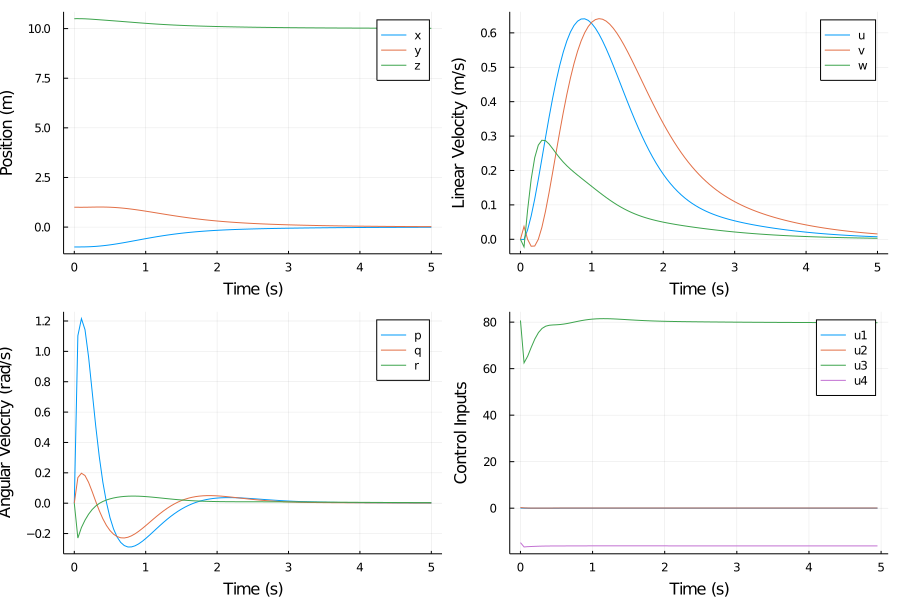

In [14]:
# Plots
comparison_plot((xhist', uhist', thist, ""))

In [15]:
vis = Visualizer()
set_heli_model!(vis)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat C:\Users\Admin\.julia\packages\MeshCat\GlCMx\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("TailRotor" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x54, 0x61, 0x69, 0x6c, 0x52, 0x6f, 0x74, 0x6f, 0x72], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"Chassis" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6f, 0x6d, 0x2f, 0x43, 0x68, 0x61, 0x73, 0x73, 0x69, 0x73], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"Rotorshaft" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x52, 0x6f, 0x74, 0x6f, 0x72, 0x73, 0x68, 0x61, 0x66, 0x74], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"fuselage" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6d, 0x2f, 0x66, 0x75, 0x73, 0x65, 0x6c, 0x61, 0x67, 0x65], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"MainRotor" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x4d, 0x61, 0x69, 0x6e, 0x52, 0x6f, 0x74, 0x6f, 0x72], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))))), Set{Any}(), ip"127.0.0.1", 8700))

In [16]:
anim = animate(vis, xhist, thist)
setanimation!(vis, anim)

In [17]:
# Straight Line Trajectory

ir, iq, iv, iw = state_parts()

X_str_init = [-10.0; 0.0; 10.0; -0.06600013368898475; 0.9978196141352584; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0]
# X_str_init = [-10.0; 0.0; 10.0; 0.01; 0.98; 0.01; 0.03; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0]
X_str_final = xhover

U_str_ref = zeros(Nu, Nt-1)
X_str_ref = zeros(Nx, Nt)

X_str_ref[:, 1] = X_str_init

dx_str = (X_str_final[ir] - X_str_init[ir]) / (Nt - 1)

for k = 1:Nt-1
    U_str_ref[:, k] = uhover
    X_str_ref[ir, k+1] = X_str_ref[ir, k] + dx_str
    dq_str = normalize(slerp(normalize(Quaternion(X_str_init[4], X_str_init[5:7])), normalize(Quaternion(X_str_final[4], X_str_final[5:7])), ((k-1)/(Nt-1))))
    X_str_ref[iq, k] = [dq_str.s; dq_str.v1; dq_str.v2; dq_str.v3]
    X_str_ref[iv, k] = (X_str_ref[ir, k+1] - X_str_ref[ir, k]) / h
end
X_str_ref[:, end] = X_str_final

# Tracking
U_str = zeros(Nu, Nt-1)
X_str = zeros(Nx, Nt)
X_str[:, 1] .= X_str_init

for k = 1:(Nt-1)
    Δx̃ = state_error(X_str[:, k], X_str_ref[:, k])
    U_str[:, k] .= U_str_ref[:, k] - K * Δx̃ 
    X_str[:, k+1] .= helicopter_dynamics_RK4(X_str[:, k], U_str[:, k], h)
end

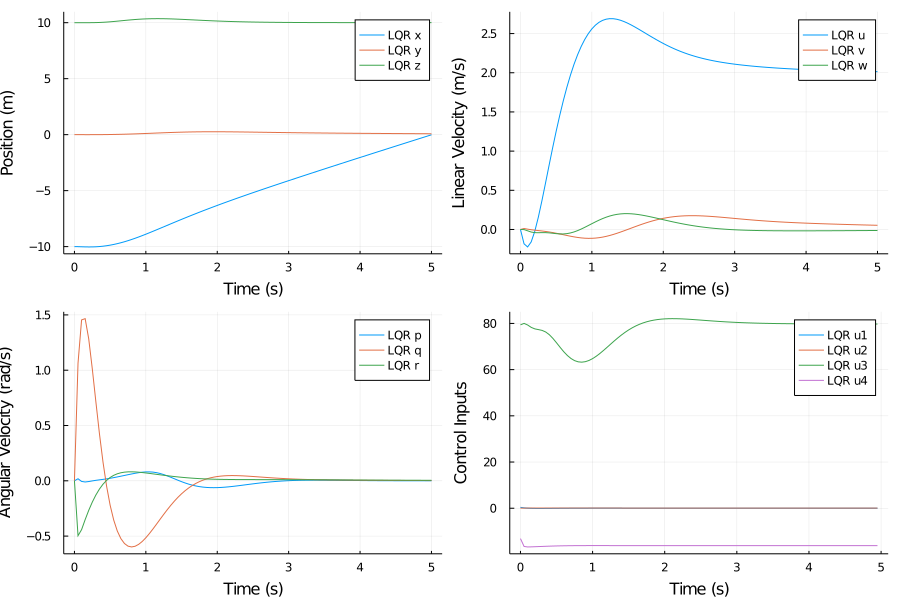

In [18]:
# Plots
comparison_plot((X_str', U_str', thist, "LQR"))

In [19]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String,MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("TailRotor" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x54, 0x61, 0x69, 0x6c, 0x52, 0x6f, 0x74, 0x6f, 0x72], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"Chassis" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6f, 0x6d, 0x2f, 0x43, 0x68, 0x61, 0x73, 0x73, 0x69, 0x73], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"Rotorshaft" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x52, 0x6f, 0x74, 0x6f, 0x72, 0x73, 0x68, 0x61, 0x66, 0x74], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"fuselage" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6d, 0x2f, 0x66, 0x75, 0x73, 0x65, 0x6c, 0x61, 0x67, 0x65], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"MainRotor" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x4d, 0x61, 0x69, 0x6e, 0x52, 0x6f, 0x74, 0x6f, 0x72], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))))), Set{Any}(), ip"127.0.0.1", 8700))

In [20]:
anim_str = animate(vis, X_str, thist)
setanimation!(vis, anim_str)

In [21]:
# MPC

# Build QP
function buildQP(Ã, B̃, Q, R, Qf, Nh, num_c)
    ñ,m = size(B̃)
    Np = (Nh-1)*(ñ+m)
    Nd = (Nh-1)*ñ
    P = spzeros(Np, Np)
    D = spzeros(Nd, Np)
    q = zeros(Np)
    #lb = zeros((Nh-1)*(ñ+4))
    #ub = zeros((Nh-1)*(ñ+4)) 
    lb = zeros((Nh-1)*(ñ+num_c))
    ub = zeros((Nh-1)*(ñ+num_c))
    
    P .= [kron(Diagonal(I,Nh-2),[R zeros(m,ñ); zeros(ñ,m) Q]) zeros((ñ+m)*(Nh-2), ñ+m); zeros(ñ+m,(ñ+m)*(Nh-2)) [R zeros(m,ñ); zeros(ñ,m) Qf]]
    D .= [[B̃ -I zeros(ñ,(Nh-2)*(m+ñ))]; zeros(ñ*(Nh-2),m) [kron(Diagonal(I,Nh-2), [Ã B̃]) zeros((Nh-2)*ñ,ñ)] + [zeros((Nh-2)*ñ,ñ) kron(Diagonal(I,Nh-2),[zeros(ñ,m) Diagonal(-I,ñ)])]]
    
    # Constraints
    #                             a b u u x y z ϕ θ ψ u v w p q r
    ϕ_c = kron(Diagonal(I, Nh-1), [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0])
    θ_c = kron(Diagonal(I, Nh-1), [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0])
    u1_c = kron(Diagonal(I, Nh-1), [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0])
    u2_c = kron(Diagonal(I, Nh-1), [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0])
    u3_c = kron(Diagonal(I, Nh-1), [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0])
    u4_c = kron(Diagonal(I, Nh-1), [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0])
    
    if num_c == 0
        return P, D, q, lb, ub
    else
#         return P, [D; u3_c; u4_c], q, lb, ub
#         return P, [D; u1_c; u2_c; u3_c; u4_c], q, lb, ub
        return P, [D; u1_c; u2_c; u3_c; u4_c; ϕ_c; θ_c], q, lb, ub
    end
    return
end
                
# Update QP
function update_QP(Ã, B̃, Q, R, Qf, Nh, Xref, Uref, x, N_t, num_c)
    ñ,m = size(B̃)
    
    Np = (Nh-1)*(ñ+m)
    Nd = (Nh-1)*ñ
    q = zeros(Np)
    lb = zeros((Nh-1)*(ñ+num_c))
    ub = zeros((Nh-1)*(ñ+num_c))
                    
    xeq = Xref[:, end]
    ueq = Uref[:, end]
    rpeq = qtorp(xeq[4:7]) 
    
    for i = 1:(Nh-1)
        index = N_t + i
        if (index > size(Xref, 2))
            index = size(Xref, 2)
        end
        q[(i*(m+ñ)-ñ+1):i*(m+ñ)] .= -Q * state_error(Xref[:, index], xeq)
        if (i == (Nh-1))
            q[(i*(m+ñ)-ñ+1):i*(m+ñ)] .= -Qf * state_error(Xref[:, index], xeq)            
        end
    end    

    #     Constraints
    lb[1:ñ] = -Ã * state_error(x, xeq)
    ub[1:ñ] = -Ã * state_error(x, xeq)
    
    if num_c != 0
    #     u1_c
        lb[Nd+0*(Nh-1)+1:Nd+1*(Nh-1)] .= -0.15 - ueq[1]
        ub[Nd+0*(Nh-1)+1:Nd+1*(Nh-1)] .= 0.15 - ueq[1]

    #     u2_c
        lb[Nd+1*(Nh-1)+1:Nd+2*(Nh-1)] .= -0.15 - ueq[2]
        ub[Nd+1*(Nh-1)+1:Nd+2*(Nh-1)] .= 0.15 - ueq[2]
        
    #     u3_c
        lb[Nd+2*(Nh-1)+1:Nd+3*(Nh-1)] .= 0 - ueq[3]
        ub[Nd+2*(Nh-1)+1:Nd+3*(Nh-1)] .= 2.5 * M * g - ueq[3]

    #     u4_c
        lb[Nd+3*(Nh-1)+1:Nd+4*(Nh-1)] .= -M * g / ntr - ueq[4]
        ub[Nd+3*(Nh-1)+1:Nd+4*(Nh-1)] .= M * g / ntr - ueq[4]

        # Roll Constraints (ϕ)
        lb[Nd+4*(Nh-1)+1:Nd+5*(Nh-1)] .= -Inf #10 - rpeq[1]
        ub[Nd+4*(Nh-1)+1:Nd+5*(Nh-1)] .= Inf #10 - rpeq[1]
        
        # Pitch Constraints (θ) 
        lb[Nd+5*(Nh-1)+1:Nd+6*(Nh-1)] .= -Inf #10 - rpeq[2]
        ub[Nd+5*(Nh-1)+1:Nd+6*(Nh-1)] .= Inf #10 - rpeq[2]

    end
    
    return q, lb, ub
end

# Solve MPC
function solve_mpc(con, hor)
    # Setting Trajectory
    U_str_mpc = zeros(Nu, Nt-1)
    X_str_mpc = zeros(Nx, Nt)
    X_str_mpc[:, 1] .= X_str_init
    
    # Setting Solver
    prob = OSQP.Model()
    P_prob, A_prob, q_prob, lb_prob, ub_prob = buildQP(Ã, B̃, Q, R, Qf, hor, con)
    OSQP.setup!(prob; P=P_prob, q=q_prob, A=A_prob, l=lb_prob, u=ub_prob, verbose=false, eps_abs=1e-8, eps_rel=1e-8, polish=1)
    
    # Rollout
    for k = 1:(Nt-1)
        q_prob, lb_prob, ub_prob = update_QP(Ã, B̃, Q, R, Qf, hor, X_str_ref, U_str_ref, X_str_mpc[:, k], k, con)
        OSQP.update!(prob, q=q_prob, l=lb_prob, u=ub_prob)
        results = OSQP.solve!(prob)
        Δu = results.x[1:Nu]
        U_str_mpc[:, k] .= U_str_ref[:, k] + Δu 
        X_str_mpc[:, k+1] .= helicopter_dynamics_RK4(X_str_mpc[:, k], U_str_mpc[:, k], h)
    end
    
    return X_str_mpc, U_str_mpc
end

solve_mpc (generic function with 1 method)

In [22]:
X_str_mpc1, U_str_mpc1 = solve_mpc(0, 51);

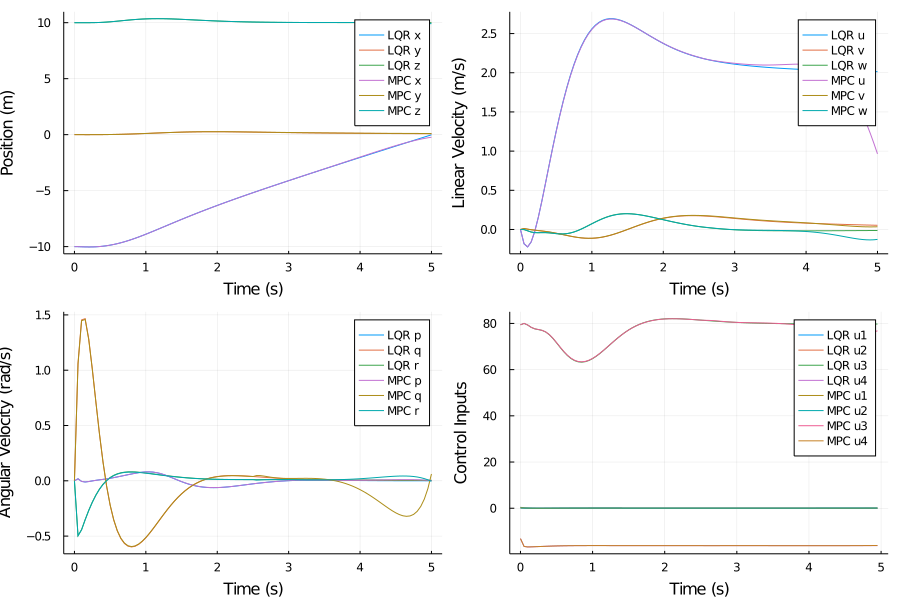

In [23]:
# Plots
comparison_plot((X_str', U_str', thist, "LQR"), (X_str_mpc1', U_str_mpc1', thist, "MPC"))

In [24]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String,MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("TailRotor" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x54, 0x61, 0x69, 0x6c, 0x52, 0x6f, 0x74, 0x6f, 0x72], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"Chassis" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6f, 0x6d, 0x2f, 0x43, 0x68, 0x61, 0x73, 0x73, 0x69, 0x73], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"Rotorshaft" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x52, 0x6f, 0x74, 0x6f, 0x72, 0x73, 0x68, 0x61, 0x66, 0x74], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"fuselage" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6d, 0x2f, 0x66, 0x75, 0x73, 0x65, 0x6c, 0x61, 0x67, 0x65], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"MainRotor" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x4d, 0x61, 0x69, 0x6e, 0x52, 0x6f, 0x74, 0x6f, 0x72], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))))), Set(Any[WebSocket(server, CONNECTED), WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8700))

In [25]:
anim_str_mpc1 = animate(vis, X_str_mpc1, thist)
setanimation!(vis, anim_str_mpc1)

In [26]:
X_str_mpc2, U_str_mpc2 = solve_mpc(6, 51);

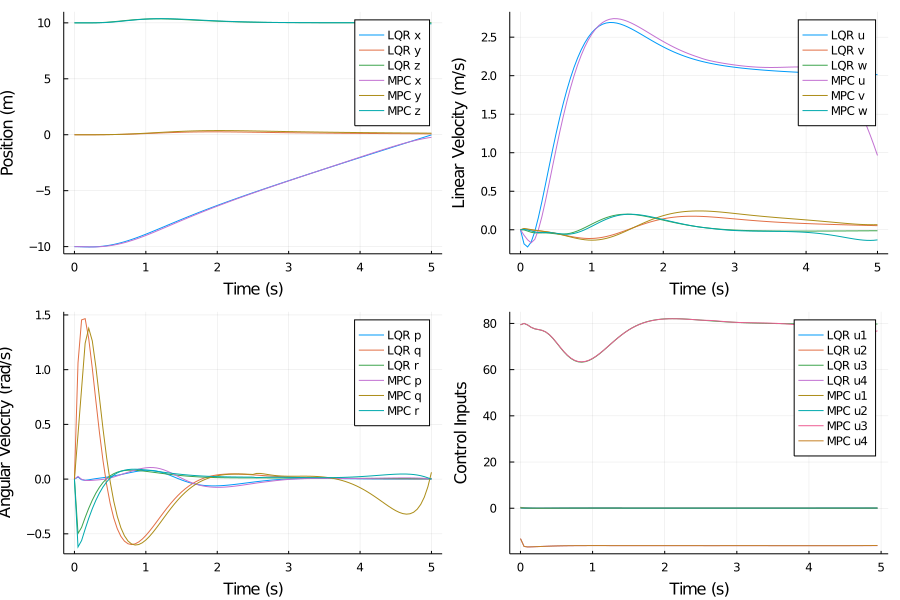

In [27]:
# Plots
comparison_plot((X_str', U_str', thist, "LQR"), (X_str_mpc2', U_str_mpc1', thist, "MPC"))

In [28]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String,MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("TailRotor" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x54, 0x61, 0x69, 0x6c, 0x52, 0x6f, 0x74, 0x6f, 0x72], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"Chassis" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6f, 0x6d, 0x2f, 0x43, 0x68, 0x61, 0x73, 0x73, 0x69, 0x73], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"Rotorshaft" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x52, 0x6f, 0x74, 0x6f, 0x72, 0x73, 0x68, 0x61, 0x66, 0x74], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"fuselage" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6d, 0x2f, 0x66, 0x75, 0x73, 0x65, 0x6c, 0x61, 0x67, 0x65], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"MainRotor" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x4d, 0x61, 0x69, 0x6e, 0x52, 0x6f, 0x74, 0x6f, 0x72], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))))), Set(Any[WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8700))

In [29]:
anim_str_mpc2 = animate(vis, X_str_mpc2, thist)
setanimation!(vis, anim_str_mpc2)

In [30]:
# Run with a bunch of horizons
horizons = [21,31,41,51,61,71,81,91,101]

Z = map(horizons) do horizon
    # Constrained MPC
    println("Running with horizon: $horizon")
    Xmpc, Umpc = solve_mpc(6, horizon)
    (Xmpc', Umpc', thist,"N = " * string(horizon))
end;

Running with horizon: 21
Running with horizon: 31
Running with horizon: 41
Running with horizon: 51
Running with horizon: 61
Running with horizon: 71
Running with horizon: 81
Running with horizon: 91
Running with horizon: 101


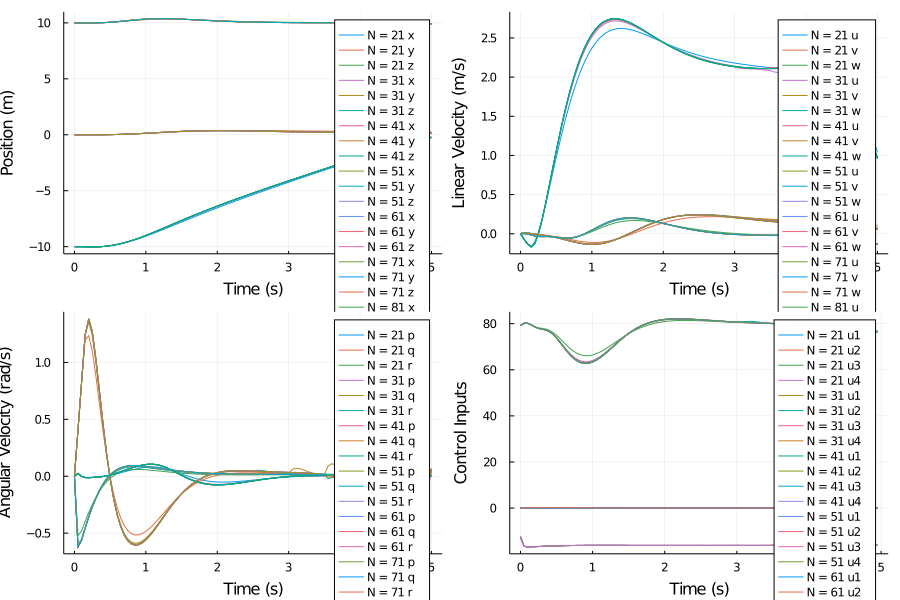

In [31]:
comparison_plot(Z...)